In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os

In [3]:
labelsCsv = pd.read_csv('data4/labels.csv')
labelsCsv

,timestamp,forward/backward,left/right
0,1635397362670,0,0
1,1635397362796,0,0
2,1635397362833,0,0
3,1635397362903,0,0
4,1635397362957,0,0
...,...,...,...
2746,1635397501683,0,0
2747,1635397501730,0,0
2748,1635397501770,0,0
2749,1635397501856,0,0


In [4]:
labelsThatExists = [i for i in range(len(labelsCsv)) if os.path.exists(f'data4/images/img_{labelsCsv["timestamp"][i]}.jpeg')]
lExists = set(labelsThatExists)

In [5]:
def getCv2ImgAtIndex(index, labelsCsv):
    ts = labelsCsv['timestamp'][index]
    if not os.path.exists(f'data4/images/img_{ts}.jpeg'):
         return np.array([])
    img = cv2.imread(f'data4/images/img_{ts}.jpeg')
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb_img

In [6]:
def dispIm(im, label="pic"):
    plt.imshow(im)
    plt.title(label)
    plt.show()

def dispGSIm(im, label='pic'):
    plt.imshow(im, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
    plt.title(label)
    plt.show()

In [7]:
diff = 14

In [8]:
def processIm(im):
#     im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#     im = cv2.blur(im, (2,2))
    #e,im = cv2.threshold(im, 200, 255, cv2.THRESH_BINARY)
#im = cv2.equalizeHist(im)
    im = cv2.resize(im, (160,120))
#     e,im = cv2.threshold(im, 226, 255, cv2.THRESH_BINARY)
    return im

In [9]:
def shiftIm(im,verbose=False):
    height = im.shape[0]
    width = im.shape[1]

    topLeft = [20,60 - diff]
    topRight = [(width - 1 - 20),60 - diff]
    bottomRight = [width -1,height-1]
    bottomLeft = [0,height - 1]
    
    if verbose:
        x = [topLeft[0],topRight[0], bottomRight[0], bottomLeft[0], topLeft[0]]
        y = [topLeft[1],topRight[1], bottomRight[1], bottomLeft[1], topLeft[1]]
        plt.plot(x, y, color="#34eb40", linewidth=3)
        plt.imshow(im, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
        plt.title('e')
        plt.show()

    srcMat = np.float32([topLeft, topRight, bottomRight, bottomLeft])
    destMat = np.float32([[0,0], [width - 1, 0], [width - 1, height -1], [0, height -1]])
    transMat = cv2.getPerspectiveTransform(srcMat, destMat)
    result = cv2.warpPerspective(im, transMat, (width, height))
    return result

In [10]:
def cropImage(im):
    return im[(im.shape[0]//2):im.shape[0],0:im.shape[1]]

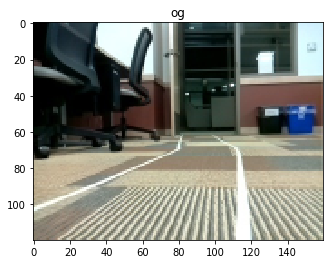

(60, 160, 3)
[[  0   0   1 ... 251 250 251]
 [  0   0   1 ... 251 251 251]
 [  0   0   1 ... 252 252 251]
 ...
 [104 110 111 ... 140 174 201]
 [109 110 112 ... 123 141 171]
 [110 106  99 ... 101 130 155]]
---
[[  0   0   2 ... 240 239 240]
 [  0   0   2 ... 240 240 240]
 [  0   0   2 ... 241 241 240]
 ...
 [122 127 125 ... 163 199 228]
 [128 127 125 ... 146 165 196]
 [126 123 114 ... 124 152 177]]
---
[[  1   0   0 ... 208 207 208]
 [  1   0   0 ... 208 208 208]
 [  1   0   0 ... 209 209 208]
 ...
 [132 136 136 ... 159 198 227]
 [135 137 139 ... 142 163 197]
 [139 133 122 ... 120 149 177]]


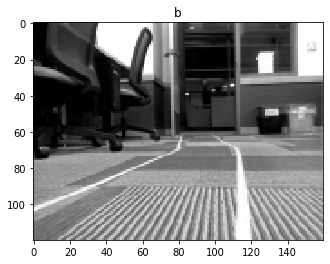

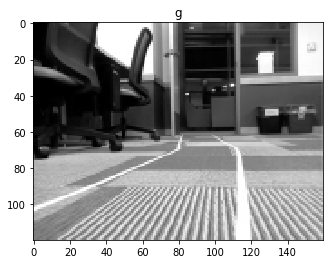

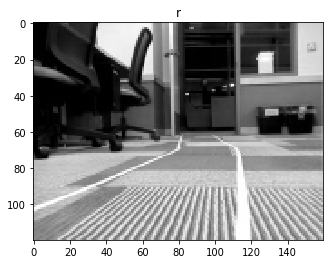

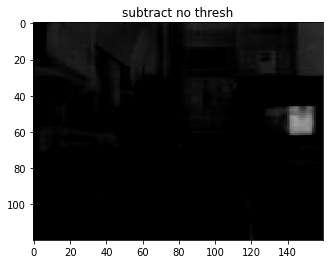

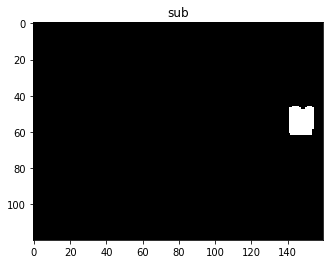

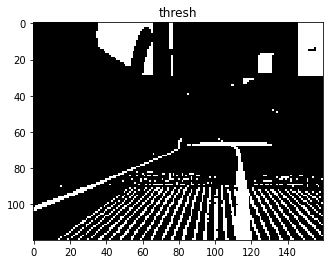

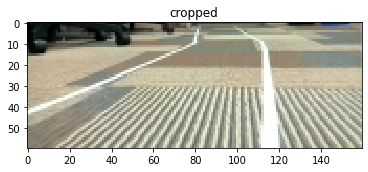

In [29]:
im = processIm(getCv2ImgAtIndex(1430,labelsCsv))
# print(im)
dispGSIm(im,'og')
# result = shiftIm(im,True)
# dispGSIm(result, 'shifted')
print(cropImage(im).shape)
m = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
r = im[:,:,0]
g = im[:,:,1]
b = im[:,:,2]
print(b)
print('---')
print(g)
print('---')
print(r)
rm = 1
e,im3 = cv2.threshold(cv2.subtract(b,cv2.multiply(rm,r)), 60, 255, cv2.THRESH_BINARY)
dispGSIm(b,'b')
dispGSIm(g,'g')
dispGSIm(r,'r')
dispGSIm(cv2.subtract(b,cv2.multiply(rm,r)),'subtract no thresh')
dispGSIm(im3, 'sub')
e,im2 = cv2.threshold(m, 200, 255, cv2.THRESH_BINARY)
dispGSIm(im2, 'thresh')

dispGSIm(cropImage(im), 'cropped')

In [569]:
imageArray = np.array([cropImage(processIm(getCv2ImgAtIndex(i,labelsCsv))).flatten() for i in labelsThatExists])
leftRightArray = np.array([labelsCsv['left/right'][i] for i in labelsThatExists])
print(imageArray.shape)
left = -1
right = 1
straight = 0

(2578, 7200)


In [570]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imageArray, leftRightArray, test_size=0.25, shuffle=True, random_state=32)

In [571]:
def classSizeLimitedTraining(X_test, y_test):
    yLInd = np.where(y_test == left)[0]
    yRInd = np.where(y_test == right)[0]
    ySInd = np.where(y_test == straight)[0]
    classSize = min(len(yLInd), len(yRInd), len(ySInd))
    np.random.seed(39)
    cl = np.random.permutation(yLInd)[:classSize]
    cr = np.random.permutation(yRInd)[:classSize]
    cs = np.random.permutation(ySInd)[:classSize]
    y_new = np.concatenate([y_test[cl],y_test[cr],y_test[cs]])
    X_new = np.concatenate([X_test[cl],X_test[cr],X_test[cs]])
    return X_new, y_new

In [572]:
X_s_train, y_s_train = classSizeLimitedTraining(X_train, y_train)

In [573]:
y_s_train.shape

(768,)

# K-NearestNeighbours

In [574]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_s_train, y_s_train)

KNeighborsClassifier()

In [575]:
y_predict = knn.predict(X_test)

In [576]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_predict)
print(f'test accuracy: {acc:.3f}')

test accuracy: 0.707


In [534]:
import pickle
save_file_name = 'knn_serialized.pickle'

with open(save_file_name, 'wb') as f:
    pickle.dump(knn, f)

In [535]:
knn_save = pickle.load(open(save_file_name, 'rb'))

In [536]:
knn_save.score(X_test, y_test)

0.6868217054263566

In [537]:
%%time
knn.predict([imageArray[0]])

CPU times: user 34.5 ms, sys: 38.9 ms, total: 73.4 ms
Wall time: 39.5 ms


array([0])

# Class Means

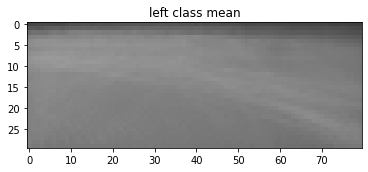

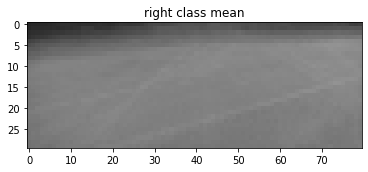

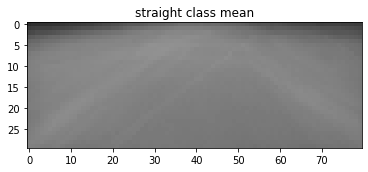

In [538]:
leftIndices = np.where(y_train == left)[0]
rightIndices = np.where(y_train == right)[0]
straightIndices = np.where(y_train == straight)[0]

leftMean = np.mean(X_train[leftIndices],axis=0)
rightMean = np.mean(X_train[rightIndices],axis=0)
straightMean = np.mean(X_train[straightIndices],axis=0)
dispGSIm(np.reshape(leftMean, (30,80)), 'left class mean')
dispGSIm(np.reshape(rightMean, (30,80)), 'right class mean')
dispGSIm(np.reshape(straightMean, (30,80)), 'straight class mean')

In [539]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

In [540]:
def nearestMean(imgFlat):
#     imgFlat = shiftIm(np.reshape(imgFlat, (60,80))).flatten()
    sd = distance(imgFlat, straightMean)
    ld = distance(imgFlat, leftMean)
    rd = distance(imgFlat, rightMean)
    if sd < ld and sd < rd:
#         dispGSIm(np.reshape(imgFlat, (60,80)),'straight')
        return 0
    elif rd < sd and rd < ld:
#         dispGSIm(np.reshape(imgFlat, (60,80)),'right')
        return 1
    else:
#         dispGSIm(np.reshape(imgFlat, (60,80)),'left')
        return -1

In [541]:
X_s_test, y_s_test = classSizeLimitedTraining(X_test, y_test)

In [542]:
y_s_pred = np.array(list(map(nearestMean, X_s_test)))
y_s_err = y_s_pred != y_s_test
errorIndices = np.where(y_s_err)[0]
def mapError(errorIndex):
    return {
        'im': X_s_test[errorIndex],
        'actual': y_s_test[errorIndex],
        'labeled': y_s_pred[errorIndex],
        'distToS': distance(X_s_test[errorIndex], straightMean),
        'distToL': distance(X_s_test[errorIndex], leftMean),
        'distToR': distance(X_s_test[errorIndex], rightMean)
    }
errors = np.array(list(map(mapError,errorIndices)))
for error in errors:
    pass
    #dispGSIm(np.reshape(error['im'],(25,80)), f"actual: {error['actual']}, labeled: {error['labeled']}, distToL: {error['distToL']:.1f}, distToS: {error['distToS']:.1f}, distToR: {error['distToR']:.1f}")
y_s_pred, y_s_test

(array([-1, -1,  1,  0, -1,  1,  0, -1, -1,  1,  1,  1,  0,  1,  0, -1,  0,
         1,  0, -1, -1, -1,  1, -1, -1, -1,  1,  0, -1, -1,  0, -1, -1,  0,
         0, -1,  1,  0,  0,  0, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,
        -1, -1, -1,  1,  1, -1,  1, -1,  0, -1, -1, -1, -1, -1,  1, -1,  1,
         1,  1, -1, -1, -1,  0,  1, -1, -1,  1,  0, -1,  1,  1,  0,  1, -1,
         1, -1,  1,  0,  1, -1, -1,  1,  1,  0,  0, -1,  1,  1, -1,  1,  1,
         1,  1,  0,  1, -1,  0,  1, -1,  0,  0,  1,  1,  0,  0,  1, -1,  1,
         0,  1, -1,  1,  1,  1,  1,  1, -1,  0,  1,  0,  1,  1,  0,  1,  1,
         1, -1,  1,  0,  1,  1,  1,  0, -1,  0,  1,  1,  0,  0,  1,  1, -1,
         1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
         0,  1,  1,  1, -1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  0,  0, -1,  0,  1,  0, -1,  1,  0,  0,  1,  0,  0, -1,  1, -1,
         0,  1,  1, -1,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  1, -1,
         0, 

In [543]:
acc = np.sum(y_s_pred == y_s_test)/len(y_s_test)
print(f'The accuracy is {acc:.3f}')

The accuracy is 0.525


In [100]:
np.save('leftMean.npy', leftMean)
np.save('rightMean.npy', rightMean)
np.save('straightMean.npy', straightMean)